# Magnetic and Diagenetic Analyses of Usui (2015)
_____

Paper doi: 10.2204/iodp.proc.334.203.2015

Core: IODP Expedition 334 Sites U1378 (8°35.5408′N, 84°04.6415′W) and U1379 (8°40.8605′N, 84°02.0274′W)

Water depth: 525 m (1378), 126 m (1379)

Data in analysis: Magnetite ppm (from Ms measurements), sedimentation rate (from tephrastrat), total organic carbon, pore water chemistry.

Tephra paper: https://doi.org/10.1002/2016GC006503


In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import data_fns
%matplotlib inline
plt.rcParams["font.family"] = "Avenir"

In [2]:
# read in data
Ms_1378 = pd.read_excel("data/usui2015.xlsx", sheet_name="U1378 Ms")
TOC_1378 = pd.read_excel("data/usui2015.xlsx", sheet_name="1378 TOC")
geochem_1378 = pd.read_excel("data/usui2015.xlsx", sheet_name="1378 geochem")
Ms_1379 = pd.read_excel("data/usui2015.xlsx", sheet_name="U1379 Ms")
TOC_1379 = pd.read_excel("data/usui2015.xlsx", sheet_name="1379 TOC")
geochem_1379 = pd.read_excel("data/usui2015.xlsx", sheet_name="1379 geochem")

# data for sed rates
ages_1378 = pd.read_excel("data/usui2015.xlsx", sheet_name="1378 tephra")
ages_1379 = pd.read_excel("data/usui2015.xlsx", sheet_name="1379 tephra")
# load in the summaries with the special adjustments we make for sample label converting function
summary_1379C = pd.read_excel("data/usui2015.xlsx", sheet_name="1379C_summary").set_index("Core").set_index("Sect", append=True)
summary_1378B =pd.read_excel("data/usui2015.xlsx", sheet_name="1378B_summary").set_index("Core").set_index("Sect", append=True)

# convert to magnetite ppm (in new column)
# divide by 1000 to get Am^2/kg, divide by 92 to get weight percent, multiply by 10^6 to go from weight percent to ppm
Ms_1378["Magnetite [ppm]"] = (Ms_1378["Ms (mAm^2/kg)"] * 10**6) / (92*1000)
Ms_1379["Magnetite [ppm]"] = (Ms_1379["Ms (mAm^2/kg)"] * 10**6) / (92*1000)

# 1379 TOC has em dashes (—) that should be replaced with np.nan
# 1379 geochem has "ND" (not detected) that should be replaced with 0
TOC_1379["TOC [wt. %]"].replace(to_replace="—", value=np.nan, inplace=True)
geochem_1379["SO4 [mM] ICP"].replace(to_replace="ND", value=np.nan, inplace=True)

Here comes a long chunk of code for dealing with sed rates. We are going to use sedimentation rates based on some age-depth points from a tephrastratigraphy paper. That paper gives sample labels at each point, but not sample depth. So we have to repurpose our sample label-sample depth converter function first used for Brachfeld (2001). That function is stored in data_fns.py, but the syntax for this application is slightly different. So below is a slightly modified version of that function, plus the necessary function calls to do the converting. We convert the 1379 and 1378 tephra separately--it's easier to keep them in separate sheets since we plot them separately.

In [3]:
# helper function to set section index correctly
def set_section(summary, split_label):
    # If CC sample, look up correct section index, which is the last item in indices list for the hole
    if split_label[3] == "CC":
        sect_ind = summary.loc[float(split_label[2][:-1])]["Top depth CSF-A (m)"].index[-1]
        # we ignored the last character of the core number because it is a letter (like H or X) and we want to look up by number only
    else:  # convert to float
        sect_ind = float(split_label[3])

    sect_top = summary.loc[float(split_label[2][:-1])]["Top depth CSF-A (m)"][sect_ind]
    return sect_top


# the main function
# assumes label intervals are in cm (probably a good assumption?)
# assumes we have a MultiIndex of Core Number/Section Number
# output is going to be a list (which you can put into a DF as a column)
def depth_convert(sample_labels, summary):
    depths = []
    for i in range(len(sample_labels)):
        # take the label string and split it by comma
        comma_split = sample_labels[i].split(",")
        # now we have the label and the interval

        # find the midpoint of the interval
        endpoints = comma_split[1].split("–") # this is an en dash
        midpoint = ((float(endpoints[0]) + float(endpoints[1][0:2])) / 200)
        # the second endpoint has " cm" after the number, so we just grab the first two characters of the string
        # divide by 200 instead of 2 b/c endpoints are in cm, not m

        # deal with the label
        label = comma_split[0].split("-") # this is a hyphen
        # now we have: [leg, hole number/letter, core number, section number]

        # only one summary sheet (per function call) for this paper
        sect_top = set_section(summary, label)

        # the mbsf depth of the sample is the interval midpoint plus the depth of the section top
        sample_depth = midpoint + sect_top
        depths.append(sample_depth)  # put this depth in the list
    # return the list of depths
    return depths

# exclude final rows of each from function call b/c they already have depths
# use loc to slice the DF so pandas doesn't get mad
# we want all the rows except the last (so get second-to-last row index)
ages_1378.loc[:ages_1378.index[-2],"Depth (CSF-A)"] = depth_convert(ages_1378.loc[:ages_1378.index[-2],"Interval"], summary_1378B)
ages_1379.loc[:ages_1379.index[-2],"Depth (CSF-A)"] = depth_convert(ages_1379.loc[:ages_1379.index[-2],"Interval"], summary_1379C)

# sort the DFs by depth so that we can calculate sed rates accurately
sorted_ages_1378 = ages_1378.sort_values(by="Depth (CSF-A)", ignore_index=True)
sorted_ages_1379 = ages_1379.sort_values(by="Depth (CSF-A)", ignore_index=True)

In [4]:
# now that we have ages and depths, we can calculate sedimentation rates
seds_1378 = data_fns.sed_rates(sorted_ages_1378["Age (Ma)"], sorted_ages_1378["Depth (CSF-A)"])
seds_1379 = data_fns.sed_rates(sorted_ages_1379["Age (Ma)"], sorted_ages_1379["Depth (CSF-A)"])

Well it took a while to get everything loaded in and sorted, but now we are all set. Next steps: create a combined DF of all info we care about (1 for each site), interpolate data, plot, then export data to the compilation spreadsheet.

In [5]:
# create dataframes of what we are interested in (from dictionaries)
magn_1378_df = pd.DataFrame({"Depth [mbsf]":Ms_1378["Top depth CSF-A (m)"], "Magnetite [ppm]":Ms_1378["Magnetite [ppm]"]})
magn_1379_df = pd.DataFrame({"Depth [mbsf]":Ms_1379["Top depth CSF-A (m)"], "Magnetite [ppm]":Ms_1379["Magnetite [ppm]"]})

geochem_1378_df = pd.DataFrame({"Depth [mbsf]":geochem_1378["Depth [mbsf]"], "Sulfate [mM]" : geochem_1378["SO4 [mM] ICP"]})
geochem_1379_df = pd.DataFrame({"Depth [mbsf]":geochem_1379["Depth [mbsf]"], "Sulfate [mM]" : geochem_1379["SO4 [mM] ICP"]})

TOC_1378_df = pd.DataFrame({"Depth [mbsf]":TOC_1378["Depth mid [mbsf]"], "TOC [wt. %]":TOC_1378["TOC [wt. %]"]})
TOC_1379_df = pd.DataFrame({"Depth [mbsf]":TOC_1379["Depth mid [mbsf]"], "TOC [wt. %]":TOC_1379["TOC [wt. %]"]})

seds_1378_df = pd.DataFrame({"Depth [mbsf]":sorted_ages_1378["Depth (CSF-A)"], "Sedimentation Rate [m/Ma]":seds_1378})
seds_1379_df = pd.DataFrame({"Depth [mbsf]":sorted_ages_1379["Depth (CSF-A)"], "Sedimentation Rate [m/Ma]":seds_1379})


# next, append them all together. We can use the result for comparison plots
# after all the appending, sort the whole thing by depth and reset index
comb_1378_df = magn_1378_df.append(geochem_1378_df).append(TOC_1378_df).append(seds_1378_df).sort_values(by="Depth [mbsf]").reset_index(drop=True)

comb_1379_df = magn_1379_df.append(geochem_1379_df).append(TOC_1379_df).append(seds_1379_df).sort_values(by="Depth [mbsf]").reset_index(drop=True)


In [6]:
# interpolate
interpolated_1378 = data_fns.interpolate(comb_1378_df, ["Sulfate [mM]", "TOC [wt. %]"])
# for 1379, the magnetite data goes much deeper than the sed rate data
# based on shipboard biostrat, the sed rate at these low depths is 412 m/Ma
interpolated_1379 = data_fns.interpolate(comb_1379_df, ["Sulfate [mM]", "TOC [wt. %]"], fill_final_rates=False)
# putting 412 in as the deepest sed rate
last_ind = interpolated_1379["Sedimentation Rate [m/Ma]"].last_valid_index()
interpolated_1379["Sedimentation Rate [m/Ma]"].iloc[last_ind + 1:] = 412

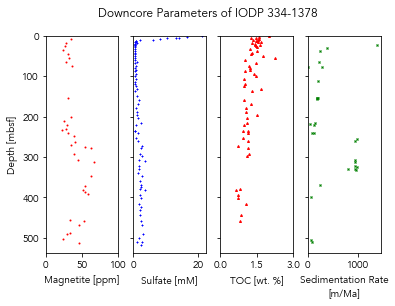

In [9]:
# for plotting, we do each site separately
# downcore plots
# 1378
colors = ["r", "b", "r", "g"]
markers = [".", "+", "^", "x"]
dc_fig_1378, dc_axs_1378 = data_fns.plot_dc(["Magnetite [ppm]", "Sulfate [mM]", "TOC [wt. %]", "Sedimentation Rate [m/Ma]"], comb_1378_df, colors, markers)
dc_axs_1378[3].set_xlabel("Sedimentation Rate\n[m/Ma]")
#dc_axs_1378[2].set_xlim(0, 3)
dc_axs_1378[2].set_xticks([0, 1.5, 3])
dc_fig_1378.suptitle("Downcore Parameters of IODP 334-1378", x=0.5)
dc_fig_1378.savefig("outputs/usui2015/1378-dc1.pdf", bbox_inches="tight")
dc_axs_1378[0].set_xlim(0, 100)
dc_fig_1378.savefig("outputs/usui2015/1378-dczoom1.pdf", bbox_inches="tight")

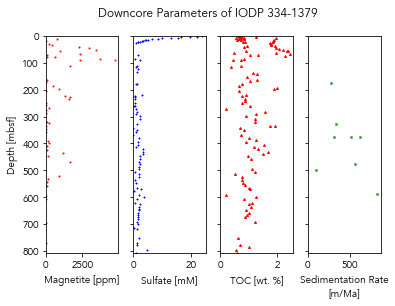

In [14]:
# 1379
dc_fig_1379, dc_axs_1379 = data_fns.plot_dc(["Magnetite [ppm]", "Sulfate [mM]", "TOC [wt. %]", "Sedimentation Rate [m/Ma]"], comb_1379_df, colors, markers)
dc_axs_1379[3].set_xlabel("Sedimentation Rate\n[m/Ma]")
dc_fig_1379.suptitle("Downcore Parameters of IODP 334-1379", x=0.5)
dc_fig_1379.savefig("outputs/usui2015/1379-dc.pdf", bbox_inches="tight")
#dc_axs_1379[0].set_xlim(0, 100)
dc_fig_1379.savefig("outputs/usui2015/1379-dc.pdf", bbox_inches="tight")

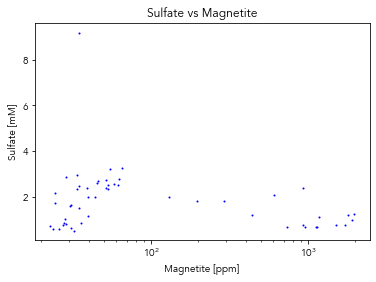

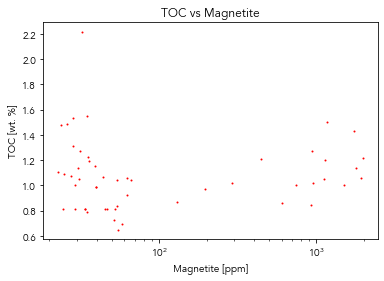

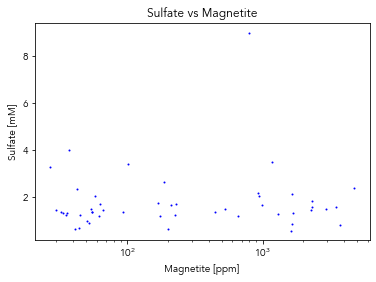

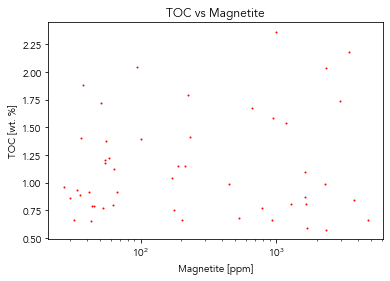

In [12]:
# comparison plots
comp_figs1378, comp_axs1378 = data_fns.plot_comp(["Sulfate [mM]", "TOC [wt. %]"], interpolated_1378, ["b", "r"], [".", "."])
comp_axs1378[0].set(xlabel="Magnetite [ppm]", ylabel="Sulfate [mM]", title="Sulfate vs Magnetite", xscale="log")
comp_axs1378[1].set(xlabel="Magnetite [ppm]", ylabel="TOC [wt. %]", title="TOC vs Magnetite", xscale="log")
comp_figs1378[0].savefig("outputs/usui2015/1378_sulf-comp.pdf")
comp_figs1378[1].savefig("outputs/usui2015/1378_toc-comp.pdf")

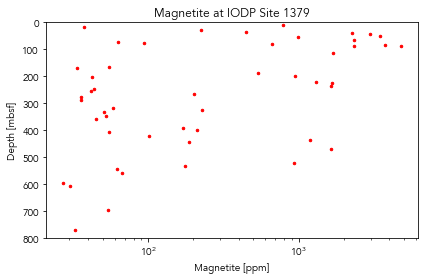

In [16]:
plt.figure()
plt.plot(comb_1379_df["Magnetite [ppm]"], comb_1379_df["Depth [mbsf]"], "r.", markersize=5)
plt.xlabel("Magnetite [ppm]")
plt.ylabel("Depth [mbsf]")
plt.title("Magnetite at IODP Site 1379")
#plt.xlim(-0.1, 500)
plt.xscale('log')
plt.ylim(0,800)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("outputs/usui2015/1379_mag-zoom.pdf")

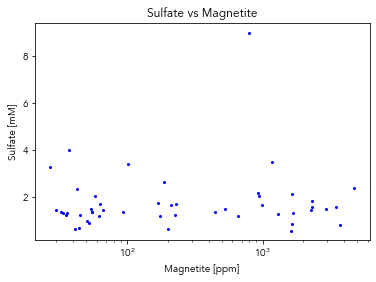

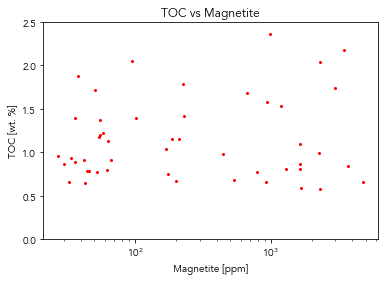

In [17]:
comp_figs1379, comp_axs1379 = data_fns.plot_comp(["Sulfate [mM]", "TOC [wt. %]"], interpolated_1379, ["b", "r"], [".", "."], markersize=4)
comp_axs1379[0].set(xlabel="Magnetite [ppm]", ylabel="Sulfate [mM]", title="Sulfate vs Magnetite", xscale="log")
comp_axs1379[1].set(xlabel="Magnetite [ppm]", ylabel="TOC [wt. %]", title="TOC vs Magnetite", xscale="log", ylim=[0,2.5])
comp_figs1379[0].savefig("outputs/usui2015/1379_sulf-comp.pdf")
comp_figs1379[1].savefig("outputs/usui2015/1379_toc-comp.pdf")

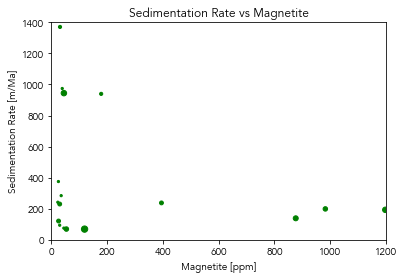

In [12]:
# plot sed rate plots separately
sed_fig1378, sed_ax1378, sed_sc1378 = data_fns.sed_avg_plot(interpolated_1378, 5)
sed_ax1378.set(xlabel="Magnetite [ppm]", ylabel="Sedimentation Rate [m/Ma]", title = "Sedimentation Rate vs Magnetite", xlim=[0,1200], ylim=[0,1400])
sed_fig1378.savefig("outputs/usui2015/1378_sed-comp.pdf")

In [ ]:
sed_fig1379, sed_ax1379, sed_sc1379 = data_fns.sed_avg_plot(interpolated_1379)
sed_ax1379.set(xlabel="Magnetite [ppm]", ylabel="Sedimentation Rate [m/Ma]", title = "Sedimentation Rate vs Magnetite")
sed_fig1379.savefig("outputs/usui2015/1379_sed-comp.pdf")

In [13]:
# compile results and add to compilation docs (one sheet for each site)
data_fns.write_output(interpolated_1378, "IODP 334-1378", "data/comp_inter.xlsx")
data_fns.write_output(comb_1378_df, "IODP 334-1378", "data/comp_raw.xlsx")

data_fns.write_output(interpolated_1379, "IODP 334-1379", "data/comp_inter.xlsx")
data_fns.write_output(comb_1379_df, "IODP 334-1379", "data/comp_raw.xlsx")